
<h1 style="color:#B42424;text-align:center;vertical-align:middle;">Introduction to Analog Quantum Computing using Aquila on AWS Braket<br>
</h1>

<h1 style="color:#B42424;">Summary</h1>

- Getting setup locally
- Overview of Aquila
- Building your first analog program
- Batching
- Further Resources

<h1 style="color:#B42424;">Getting setup locally</h1>

- You may want to classically simulate analog programs on your local computer before submitting to Aquila.
- I created a public GitHub repo to help you get started. It includes this slideshow!
- To get access, you can either
    - Type and run the following in a terminal `git clone https://github.com/Kenny-Heitritter/Intro-to-Analog-Quantum-Computing.git`
    - Navigate to https://github.com/Kenny-Heitritter/Intro-to-Analog-Quantum-Computing using a web browser and download the zip file by clicking the green code button.

- Navigate to the directory where you downloaded the repository
- Run the following:
    - conda create -n ahs pip
    - conda activate ahs
    - pip install -r requirements.txt
- Once finished, open a new jupyter notebook by running `jupyter-notebook` in a terminal
- Run the following cell to confirm your install worked

In [3]:
import braket._sdk as braket_sdk
braket_sdk.__version__

'1.35.3'

- Success, we're good to go!

<h1 style="color:#B42424;">Overview of Aquila</h1>

- Aquila is a cloud-accessible (AWS Braket) programmable array of neutral Rubidium atoms
- For all details about the device go to https://www.quera.com/aquila


- For details particular to AWS Braket
    - Login to AWS
    - Navigate to Braket
    - Click 'Devices' on left side
    - Under list of devices, find 'QuEra' and click 'Aquila' on same line
- This page lists
    - Costs: \\$0.30 / task + \\$0.01 / shot
    - Availability: 
        - Tuesday, 16:00:00 - 20:00:00 UTC
        - Wednesday, 16:00:00 - 20:00:00 UTC
        - Thursday, 16:00:00 - 18:00:00 UTC
    - Calibration data
    - etc..
    
    

- If you have an IAM role setup (or are using a notebook on AWS Braket), then you can access calibration data (and more) by running the following

In [10]:
from braket.aws import AwsDevice 
import pprint


# Sets the device to Aquila
qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

# Gives us the capabilities of Aquila
capabilities = qpu.properties.paradigm
rydberg = capabilities.rydberg
print(rydberg)

c6Coefficient=Decimal('5.42E-24') rydbergGlobal=RydbergGlobal(rabiFrequencyRange=(Decimal('0.0'), Decimal('15800000.0')), rabiFrequencyResolution=Decimal('400.0'), rabiFrequencySlewRateMax=Decimal('250000000000000.0'), detuningRange=(Decimal('-125000000.0'), Decimal('125000000.0')), detuningResolution=Decimal('0.2'), detuningSlewRateMax=Decimal('2500000000000000.0'), phaseRange=(Decimal('-99.0'), Decimal('99.0')), phaseResolution=Decimal('5E-7'), timeResolution=Decimal('1E-9'), timeDeltaMin=Decimal('5E-8'), timeMin=Decimal('0.0'), timeMax=Decimal('0.000004'))


<h1 style="color:#B42424;">Building your first analog program</h1>

- Analog devices do not use a standard set of gates
- Instead, you specify Hamiltonian parameters (Rabi, detuning, phase, position) as functions of time
    - Remember though that there are constraints on the range of allowed parameters and on how they can change

- Let's first import some necessary pieces

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from ahs_utils import show_register, show_global_drive, show_final_avg_density, get_drive
from braket.devices import LocalSimulator
from braket.aws import AwsDevice 

# Sets the device to Aquila
qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

# Gives us the capabilities of Aquila
capabilities = qpu.properties.paradigm
rydberg = capabilities.rydberg

- Next, let's state what configuration of atoms we want to simulate. We have to specify the (x,y) position of each atom and append it to a special list.

In [5]:
atoms = AtomArrangement()

height = 10e-6
x_spacing = 6e-6

for i in range(7):
    atoms.add([i*x_spacing, height])

- We can get a picture of the atom configuration using one of the helper functions defined in ahs_utils.py

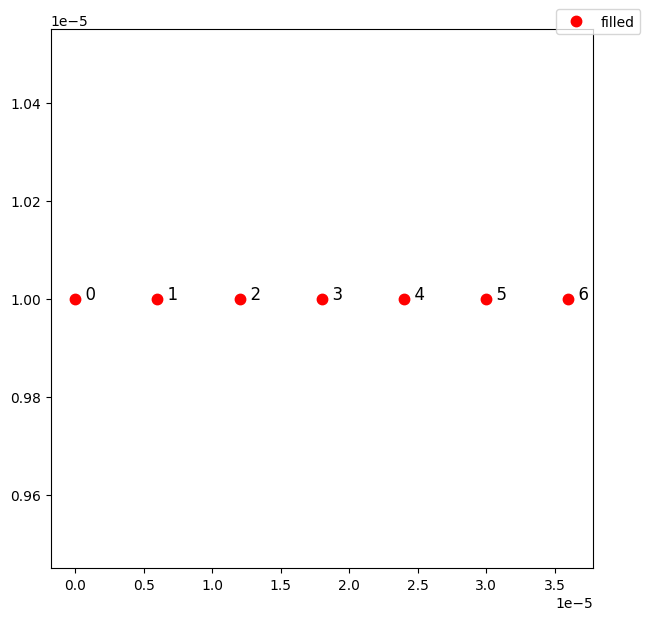

In [6]:
show_register(atoms)

- We now need to say how this configuration of atoms will evolve
- There are some important physical limitations here:
    - The Rabi frequency has to start with 0 rad/s
    - The Rabi frequency has to end with 0 rad/s
    - The phase has to start with 0 rad
    - All the parameters we describe have to have the same duration

- Let's start simple...
    - Define evolution using four points
    - At the first point, all fields start at zero
    - At the second point, Rabi frequency is raised to 4Pi MHz while all other fields are zero
    - The third point will have same parameters as the second.
    - The fourth point will send the Rabi frequency to zero

- The parameters can only be changed up to a certain speed called the maximum slew rate.
- Can extract this value via the following line

In [24]:
max_slew = float(rydberg.rydbergGlobal.rabiFrequencySlewRateMax) # rad/s^2. previously advised to only use 95% of maximum
print("{:e}".format(max_slew))

2.500000e+14


- Suppose we want the Rabi frequency to reach 4Pi MHz as quickly as possible and then stay there as long as possible

In [25]:
omega_min = 0 # rad/s
omega_max = np.pi*4.0e6 # rad/s

ramp_time = omega_max/(max_slew*0.95)
print(ramp_time)

5.291103416572283e-08


In [19]:
total_time = 4.0e-6

time_points = [0, ramp_time, total_time-ramp_time, total_time]

- Given the ramp time and total evolution time, we have specified all the time points
- We now need to specify the values of each parameter for each time

In [22]:
omega_values = [omega_min, omega_max, omega_max, omega_min]
detuning_values = [0, 0, 0, 0]
phase_values = [0, 0, 0, 0]

drive = get_drive(time_points, omega_values, detuning_values, phase_values)

- Plot the time values of our program using anothing helper function from ahs_utils.py

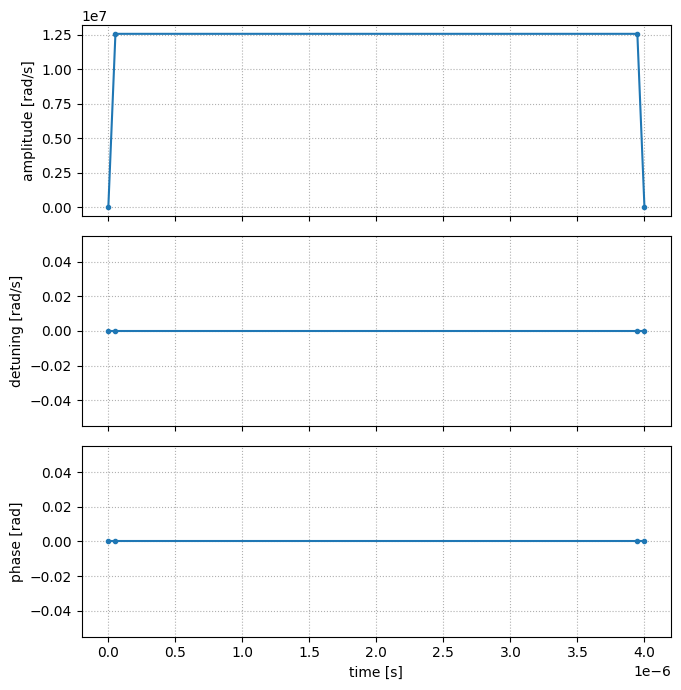

In [23]:
show_global_drive(drive)

- Now we need to put the atom arrangement and 'drive' together to create the full program

In [26]:
program = AnalogHamiltonianSimulation(
    register=atoms,
    hamiltonian=drive
)

- When we run this program on the real Aquila QPU, we will need to make absolutely sure that it doesn't break any of the physical constraints. Digitizing the program will either throw an error, if we specified something impossible, or pass if there are no issues.

In [27]:
d_program = program.discretize(qpu)


- Just like for any other braket simulation, we now specify the device to use and then run. Here, we use the local simulator, but you should try specifying Aquila sometime in the future.

In [41]:
device = LocalSimulator("braket_ahs")
result = device.run(d_program, progress_bar=True, shots = 10).result()

In [42]:
print(result)

AnalogHamiltonianSimulationQuantumTaskResult(task_metadata=TaskMetadata(braketSchemaHeader=BraketSchemaHeader(name='braket.task_result.task_metadata', version='1'), id='rydberg', shots=10, deviceId='rydbergLocalSimulator', deviceParameters=None, createdAt=None, endedAt=None, status=None, failureReason=None), measurements=[ShotResult(status=<AnalogHamiltonianSimulationShotStatus.SUCCESS: 'Success'>, pre_sequence=array([1, 1, 1, 1, 1, 1, 1]), post_sequence=array([1, 1, 1, 1, 1, 1, 1])), ShotResult(status=<AnalogHamiltonianSimulationShotStatus.SUCCESS: 'Success'>, pre_sequence=array([1, 1, 1, 1, 1, 1, 1]), post_sequence=array([1, 1, 1, 1, 1, 1, 1])), ShotResult(status=<AnalogHamiltonianSimulationShotStatus.SUCCESS: 'Success'>, pre_sequence=array([1, 1, 1, 1, 1, 1, 1]), post_sequence=array([1, 1, 1, 1, 0, 1, 1])), ShotResult(status=<AnalogHamiltonianSimulationShotStatus.SUCCESS: 'Success'>, pre_sequence=array([1, 1, 1, 1, 1, 1, 1]), post_sequence=array([1, 1, 1, 0, 1, 1, 0])), ShotResult(s

In [43]:
result.measurements

[ShotResult(status=<AnalogHamiltonianSimulationShotStatus.SUCCESS: 'Success'>, pre_sequence=array([1, 1, 1, 1, 1, 1, 1]), post_sequence=array([1, 1, 1, 1, 1, 1, 1])),
 ShotResult(status=<AnalogHamiltonianSimulationShotStatus.SUCCESS: 'Success'>, pre_sequence=array([1, 1, 1, 1, 1, 1, 1]), post_sequence=array([1, 1, 1, 1, 1, 1, 1])),
 ShotResult(status=<AnalogHamiltonianSimulationShotStatus.SUCCESS: 'Success'>, pre_sequence=array([1, 1, 1, 1, 1, 1, 1]), post_sequence=array([1, 1, 1, 1, 0, 1, 1])),
 ShotResult(status=<AnalogHamiltonianSimulationShotStatus.SUCCESS: 'Success'>, pre_sequence=array([1, 1, 1, 1, 1, 1, 1]), post_sequence=array([1, 1, 1, 0, 1, 1, 0])),
 ShotResult(status=<AnalogHamiltonianSimulationShotStatus.SUCCESS: 'Success'>, pre_sequence=array([1, 1, 1, 1, 1, 1, 1]), post_sequence=array([1, 1, 0, 1, 1, 1, 1])),
 ShotResult(status=<AnalogHamiltonianSimulationShotStatus.SUCCESS: 'Success'>, pre_sequence=array([1, 1, 1, 1, 1, 1, 1]), post_sequence=array([1, 0, 1, 1, 1, 1, 0]))

- Some more helper functions exist for letting do a quick analysis

{'ggggggg': 2, 'ggggrgg': 1, 'gggrggr': 1, 'ggrgggg': 1, 'grggggr': 1, 'grggrgg': 1, 'rgggggg': 1, 'rggggrg': 1, 'rgggrgr': 1}
[0.3 0.2 0.1 0.1 0.3 0.1 0.3]


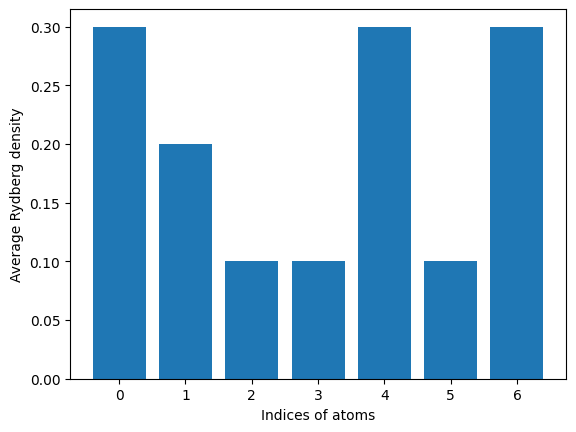

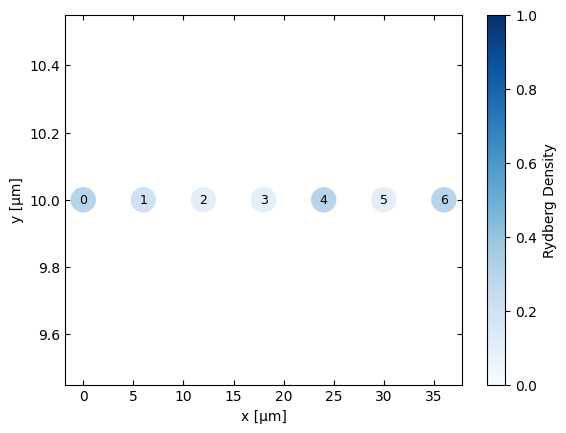

In [46]:
from ahs_utils import get_counts, get_avg_density, show_final_avg_density, plot_avg_density_2D

print(get_counts(result))

print(get_avg_density(result))

show_final_avg_density(result)

plot_avg_density_2D(get_avg_density(result),atoms)


<h1 style="color:#B42424;">Batching</h1>

- We can take advantage of the fact that many copies of a system can be placed within the field-of-view for Aquila in a way that multiplies our effective shots
- For example, suppose we wanted to run the previous seven atom program on Aquila. We could increase the number of effective shots by placing copies an appropriate distance away from each other


- To do this, we need to know the available space on Aquila

In [48]:
field_of_view_width = qpu.properties.paradigm.lattice.area.width
print(field_of_view_width)
field_of_view_height = qpu.properties.paradigm.lattice.area.height
print(field_of_view_height)

0.000075
0.000076


- Our previous program had atoms spaced by 6 micrometers and Rydberg interaction goes like 1/r^6
- Could easily get away with placing copies a distance of 18 micrometers apart vertically

In [52]:
(1/(6**6))/(1/((3*6)**6))

728.9999999999999

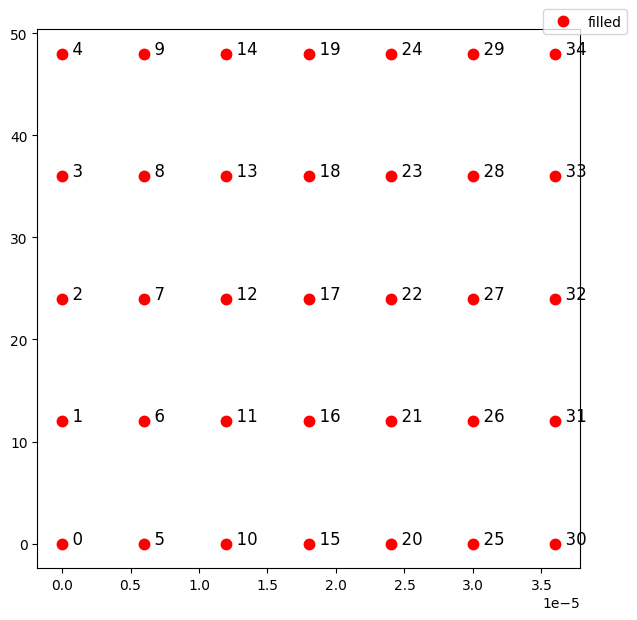

In [61]:
batched_atoms = AtomArrangement()

batch_spacing = 18-6
x_spacing = 6e-6

for i in range(7):
    for j in range(5): # number of copies
        batched_atoms.add([i*x_spacing, j*batch_spacing])
        
show_register(batched_atoms)

- This is the basic idea of batching with Aquila
- Note that you won't be able to simulate the batched results due to the number of atoms
- You should be very careful that you don't accidentally introduce interactions that are non-negligable